# Mind Reading:
## Using Artificial Neural Nets to Predict Viewed Image Categories From EEG Readings
This notebook provides a convolutional neural network (CNN) as an alternative to the linear discriminant analysis used in this study: https://purl.stanford.edu/bq914sc3730

### Data Download

In [1]:
data_path = "data"
basename = "Kaneshiro_etAl_objectCategoryEEG"
filename = basename + ".zip"

!mkdir -p {data_path}
!wget -nc https://stacks.stanford.edu/file/druid:bq914sc3730/{filename} -O {data_path}/{filename}
!unzip -n {data_path}/{filename} -d {data_path}

File `data/Kaneshiro_etAl_objectCategoryEEG.zip' already there; not retrieving.
Archive:  data/Kaneshiro_etAl_objectCategoryEEG.zip


### Data Exploration
There are 10 MATLAB files each corresponding to a human test subject.

In [2]:
training_path = data_path + '/' + basename

from scipy.io import loadmat

subjects_count = 10
subjects = []
for i in range(0, subjects_count):
    filename = "S" + str(i + 1) + ".mat"
    subjects.append(loadmat(training_path + "/" + filename))

subjects[0]

{'Fs': array([[ 62.5]]),
 'N': array([[32]], dtype=uint8),
 'T': array([[5188]], dtype=uint16),
 'X': array([[-0.26424164, -0.47586018, -0.47061757, ...,  0.05198565,
          0.08307296, -0.04543913],
        [ 0.0028675 , -0.04133774,  0.05108967, ...,  0.09525956,
         -0.00872008,  0.12494965],
        [-0.22358645,  0.02478356,  0.08543183, ...,  0.0938575 ,
          0.06906053,  0.09690079],
        ..., 
        [ 0.17795506, -0.06740315,  0.09080031, ..., -0.11675177,
         -0.19592201, -0.16641006],
        [ 0.18887348,  0.17863007,  0.32982534, ...,  0.10712342,
          0.10700955,  0.0652873 ],
        [ 0.02932549, -0.05199817, -0.15791252, ..., -0.09192452,
         -0.04275392,  0.08084101]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Feb  6 14:21:30 2015',
 '__version__': '1.0',
 'categoryLabels': array([[4, 6, 3, ..., 5, 1, 1]], dtype=uint8),
 'exemplarLabels': array([[40, 64, 29, ..., 59,  3, 12]], dtype=uin

The README file found in the link above provides the data dictionary. Looking at the data for the first test subject above:
* sampling frequency 'Fs' was 62.5 Hz
* number of time samples 'N' per trial was 32, so each trial lasted (32 samples) / (62.5 samples per second) == 0.512 seconds
* number of trials 'T' was 5188
* X is the EEG data
* 'categoryLabels' are the numbers corresponding to which type of image the test subject looked at for each trial

Inspect the EEG data for the first trial of the first subject:

In [3]:
trial1 = subjects[0]['X'][0]
print(trial1.shape)
print(trial1)

(3968,)
[-0.26424164 -0.47586018 -0.47061757 ...,  0.05198565  0.08307296
 -0.04543913]


The EEG device had 124 different electrodes surrounding the person's head. And each electrode took 32 samples, so 124 * 32 == 3968, which matches the shape of the trial1 variable as seen above.

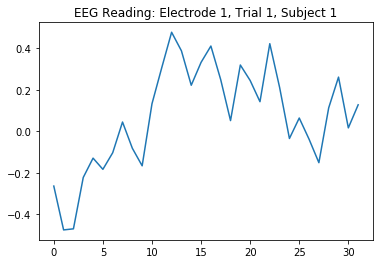

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

N = 32
plt.plot(trial1[:N])
plt.title("EEG Reading: Electrode 1, Trial 1, Subject 1")

#### Imagine each trial as a 32 x 124 heatmap image
Might a CNN detect patterns in the images of each trial to correctly categorize them?

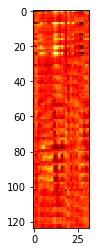

In [5]:
import numpy as np

electrodes = 124
trial_image = np.reshape(trial1, (electrodes, N))
plt.imshow(trial_image, cmap='hot', interpolation='nearest')

### Data Preparation

Concatenate all trials and output target labels from the first 9 test subjects. The last subject will be our holdout/validation set.

**Note:** In the original Stanford paper, it's not clear whether the authors ensured that EEG reading trials from the same test subject weren't in both the training and holdout sets. That condition is necessary in order to gauge the generalizeability of their classier onto new people.

In [6]:
trials = np.concatenate([subjects[i]['X'] for i in range(9)])
y_training = np.concatenate([subjects[i]['categoryLabels'][0] for i in range(9)])

Double-check number of trials equals number of target output labels and inspect a few samples:

In [7]:
print(len(trials), len(y_training))
print(y_training)

46673 46673
[4 6 3 ..., 5 2 4]


In [8]:
trials[0]

array([-0.26424164, -0.47586018, -0.47061757, ...,  0.05198565,
        0.08307296, -0.04543913])

In [9]:
len(trials[0])

3968

### Define Training and Validation/Holdout Sets

In [10]:
X_training = trials

holdout_fold = subjects[9]
X_validation = holdout_fold['X']
print(len(X_validation), X_validation)

5184 [[ 0.63071699  0.53238287  0.56498052 ...,  0.02870825  0.02721558
   0.34215394]
 [ 0.12276634  0.07957858  0.00199308 ..., -0.00191029 -0.05771172
  -0.02692576]
 [-0.03659082 -0.08075532 -0.10016629 ..., -0.01577061  0.0127475
   0.08241198]
 ..., 
 [ 0.12776493  0.02066169 -0.11780883 ..., -0.00844402  0.10320733
   0.06531146]
 [-0.24601796 -0.18427435 -0.02046263 ...,  0.20250326  0.26181931
  -0.04597046]
 [ 0.16304573  0.0402427   0.02112196 ..., -0.018746    0.3735711
   0.00758652]]


In [11]:
y_validation = holdout_fold['categoryLabels'][0]
print(len(y_validation), y_validation)

5184 [1 6 1 ..., 6 4 6]


### Class Balance Check
Are the image categories equally represented in the data? In the histograms below, we set the number of bins to twice the number of categories for better spacing.

(array([ 7787.,     0.,  7777.,     0.,  7778.,     0.,     0.,  7779.,
            0.,  7776.,     0.,  7776.]),
 array([ 1.        ,  1.41666667,  1.83333333,  2.25      ,  2.66666667,
         3.08333333,  3.5       ,  3.91666667,  4.33333333,  4.75      ,
         5.16666667,  5.58333333,  6.        ]),
 <a list of 12 Patch objects>)

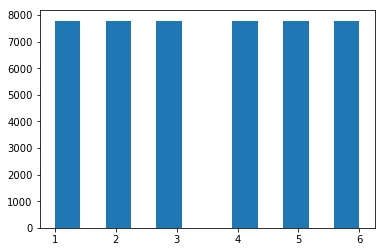

In [12]:
plt.hist(y_training, bins = 12)

(array([ 864.,    0.,  864.,    0.,  864.,    0.,    0.,  864.,    0.,
         864.,    0.,  864.]),
 array([ 1.        ,  1.41666667,  1.83333333,  2.25      ,  2.66666667,
         3.08333333,  3.5       ,  3.91666667,  4.33333333,  4.75      ,
         5.16666667,  5.58333333,  6.        ]),
 <a list of 12 Patch objects>)

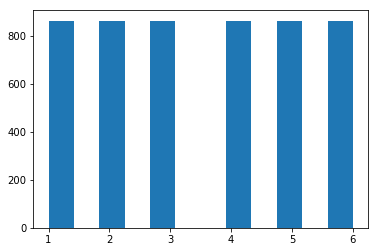

In [13]:
plt.hist(y_validation, bins=12)

### Re-shape training and validation sets

Transform into array of 32 x 124 grayscale "heatmap" images:

In [14]:
X_training[0].shape

(3968,)

In [15]:
X_training.shape

(46673, 3968)

In [16]:
X_training = np.reshape(X_training, (-1, electrodes, N, 1)) # no color
X_training.shape

(46673, 124, 32, 1)

In [17]:
print(X_validation.shape)
X_validation = np.reshape(X_validation, (-1, electrodes, N, 1))
X_validation.shape

(5184, 3968)


(5184, 124, 32, 1)

### 1-Hot Encode Target Output Labels

In [18]:
import keras

num_classes = 6
y_training1hot = keras.utils.to_categorical(y_training - 1, num_classes) # We subtract 1 to convert to 0-index
y_validation1hot = keras.utils.to_categorical(y_validation - 1, num_classes)

Using TensorFlow backend.


### CNN Model Definition and Training

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X_training.shape[1:]))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

history = model.fit(X_training, y_training1hot, 
                    epochs=256, 
                    validation_data=(X_validation, y_validation1hot), 
                    shuffle=True)

Train on 46673 samples, validate on 5184 samples
Epoch 1/256
46673/46673 [==============================] - 35s - loss: 1.7026 - acc: 0.2832 - val_loss: 1.7138 - val_acc: 0.2701
Epoch 2/256
46673/46673 [==============================] - 26s - loss: 1.5595 - acc: 0.3631 - val_loss: 1.7657 - val_acc: 0.2589
Epoch 3/256
46673/46673 [==============================] - 26s - loss: 1.4479 - acc: 0.4133 - val_loss: 1.7055 - val_acc: 0.2861
Epoch 4/256
46673/46673 [==============================] - 26s - loss: 1.3358 - acc: 0.4624 - val_loss: 1.7885 - val_acc: 0.2930
Epoch 5/256
46673/46673 [==============================] - 26s - loss: 1.2190 - acc: 0.5111 - val_loss: 2.0166 - val_acc: 0.2782
Epoch 6/256
46673/46673 [==============================] - 26s - loss: 1.1058 - acc: 0.5558 - val_loss: 2.3112 - val_acc: 0.2629
Epoch 7/256
46673/46673 [==============================] - 26s - loss: 1.0006 - acc: 0.5995 - val_loss: 2.3274 - val_acc: 0.2593
Epoch 8/256
46673/46673 [=======================

In [20]:
model.save_weights('weights.hdf5')

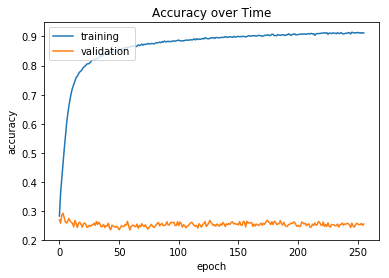

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy over Time')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

The accuracy of the holdout set (i.e, last test subject) holds steady at 25%, which is better than random guessing (1 out of 6 image categories == 16.67%), while the accuracy continues to improve for the training set (the first 9 test subjects) although it seems to converging to 90% or so.

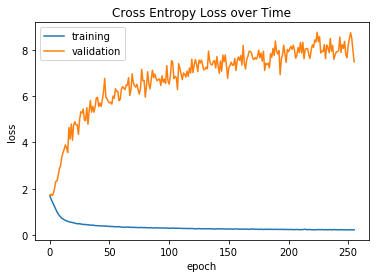

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cross Entropy Loss over Time')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

However, the cross entropy loss of the validation set increases.

** Exercise for the reader:** Cross-validation

### Model Quality Check: Confusion Matrix

4832/5184 [==========================>...] - ETA: 0sConfusion matrix, without normalization
[[185 136 141  89 134 179]
 [122 337 102  42 106 155]
 [106 138 214  91 159 156]
 [192 149 145 183  88 107]
 [160 116 144  98 192 154]
 [131 124 127  70 197 215]]


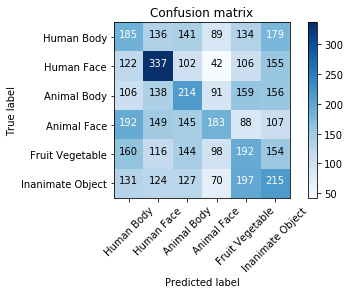

In [23]:
import itertools
from sklearn.metrics import confusion_matrix

y_validation_predictions = model.predict(X_validation, verbose=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_validation - 1, np.argmax(y_validation_predictions, axis=1))

plt.figure()
class_names = ['Human Body', 'Human Face', 'Animal Body', 'Animal Face', 'Fruit Vegetable', 'Inanimate Object']
plot_confusion_matrix(cnf_matrix, classes=class_names)

The neuroscientists and psychologists that may be reading this are probably not surprised that human faces are easily recognized.
## Where to go from here...
We hope you expand upon this initial work on using artificial neural networks to analyze EEG data. In addition to adding cross-validation, as mentioned previously, might different neural network architectures and hyperparameters perform better? 